In [111]:
!pip install SimpleITK
!pip install diskcache

     |████████████████████████████████| 51kB 3.7MB/s 


In [128]:
import pandas as pd
import numpy as np
import os
import functools
import glob
import csv
from collections import namedtuple
import re
import tqdm
import SimpleITK as sitk
from torch.utils.data import Dataset
import copy
import torch
from diskcache import FanoutCache, Disk
import matplotlib.pyplot as plt

In [57]:
os.chdir('/content/drive/MyDrive/DataML')

In [19]:
annotations = pd.read_csv('annotations.csv')


In [20]:
candidates = pd.read_csv('candidates.csv')

In [21]:
candidates

,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-56.08,-67.85,-311.92,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,53.21,-244.41,-245.17,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.66,-121.80,-286.62,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-33.66,-72.75,-308.41,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-32.25,-85.36,-362.51,0
...,...,...,...,...,...
551060,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,-55.66,37.24,-110.42,0
551061,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,68.40,70.18,-109.72,0
551062,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,-82.29,-27.94,-106.92,0
551063,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,38.26,83.50,-102.71,0


In [22]:
annotations

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150
...,...,...,...,...,...
1181,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,-160.856298,-28.560349,-269.168728,5.053694
1182,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,-102.189570,-73.865766,-220.536241,4.556101
1183,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,-37.535409,64.041949,-127.687101,4.357368
1184,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,43.196112,74.438486,-200.523314,4.277203


In [23]:
sum(candidates['class'] == 1) # Number of malignant cases

1351

In [24]:
t1 = candidates['seriesuid'][0]

In [25]:
annotations[annotations['seriesuid'] == t1]

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708


In [26]:
candidates[candidates['seriesuid'] == t1]

,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-56.080000,-67.850000,-311.920000,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,53.210000,-244.410000,-245.170000,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.660000,-121.800000,-286.620000,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-33.660000,-72.750000,-308.410000,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-32.250000,-85.360000,-362.510000,0
...,...,...,...,...,...
686,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,138.651905,-107.023000,-299.187989,0
687,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-60.199049,-178.785827,-211.598168,0
688,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-90.207559,-106.338054,-238.715592,0
689,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,121.515979,-105.655813,-352.912500,0


In [117]:
@functools.lru_cache(1)
def create_candidate_frame(on_disk = True):

  all_on_disk = glob.glob('subset*/*.mhd')
  only_names = [re.search(r'subset\d/(.*).mhd', x).group(1) for x in all_on_disk]

  annotations_frame = pd.read_csv('annotations.csv')
  annotations_frame = annotations_frame[annotations_frame['seriesuid'].isin(only_names)]
  annotations_frame = annotations_frame.reset_index()

  diameters_dict = {}
  for name in only_names:
    diameters_dict[name] = [row.to_list() for i, row in annotations_frame[annotations_frame['seriesuid'] == name].iloc[:, -4:].iterrows()]
    

  candidates_frame = pd.read_csv('candidates.csv')
  candidates_frame = candidates_frame[candidates_frame['seriesuid'].isin(only_names)]
  candidates_frame['diameter_mm'] = [0.0 for i in range(len(candidates_frame))]

  with open('candidates.csv', "r") as f:
      for index, row in tqdm.tqdm(enumerate(list(csv.reader(f))[1:])):
          
          uid = row[0]   
          if uid not in diameters_dict.keys():
              continue

          coords = [float(x) for x in row[1:4]]
          class_ = row[4]

          candidateDiameter_mm = 0.0
          for annotation_tup in diameters_dict.get(uid, []):
              annotationCenter_xyz = annotation_tup
              for i in range(3):
                  delta_mm = abs(coords[i] - annotation_tup[i])
                  if delta_mm > annotation_tup[3] / 4:
                      break
              else:
                  candidates_frame.loc[index, 'diameter_mm'] = annotation_tup[3]
                  break

  return  candidates_frame.sort_values('diameter_mm', ascending=False)


In [118]:
candidates_frame = create_candidate_frame() 

551065it [00:02, 263398.22it/s]


In [119]:
candidates_frame

,seriesuid,coordX,coordY,coordZ,class,diameter_mm
333141,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644...,67.614517,85.025260,-109.808442,1,32.270030
21730,1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331...,47.903505,37.604420,-99.934176,1,30.610406
21367,1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331...,40.690000,32.190000,-97.150000,1,30.610406
21354,1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331...,44.190000,37.790000,-107.010000,1,30.610406
538550,1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251...,-45.294402,74.869254,-97.528125,1,27.442423
...,...,...,...,...,...,...
182748,1.3.6.1.4.1.14519.5.2.1.6279.6001.199670099218...,13.270000,34.470000,-149.780000,0,0.000000
182747,1.3.6.1.4.1.14519.5.2.1.6279.6001.199670099218...,44.800000,89.120000,-149.080000,0,0.000000
182746,1.3.6.1.4.1.14519.5.2.1.6279.6001.199670099218...,-39.970000,52.690000,-222.150000,0,0.000000
182745,1.3.6.1.4.1.14519.5.2.1.6279.6001.199670099218...,40.600000,56.890000,-209.500000,0,0.000000


In [30]:
IrcTuple = namedtuple('IrcTuple', ['index', 'row', 'col'])
XyzTuple = namedtuple('XyzTuple', ['x', 'y', 'z'])

def irc2xyz(coord_irc, origin_xyz, vxSize_xyz, direction_a):
    cri_a = np.array(coord_irc)[::-1]
    origin_a = np.array(origin_xyz)
    vxSize_a = np.array(vxSize_xyz)
    coords_xyz = (direction_a @ (cri_a * vxSize_a)) + origin_a
    # coords_xyz = (direction_a @ (idx * vxSize_a)) + origin_a
    return XyzTuple(*coords_xyz)

def xyz2irc(coord_xyz, origin_xyz, vxSize_xyz, direction_a):
    origin_a = np.array(origin_xyz)
    vxSize_a = np.array(vxSize_xyz)
    coord_a = np.array(coord_xyz)
    cri_a = ((coord_a - origin_a) @ np.linalg.inv(direction_a)) / vxSize_a
    cri_a = np.round(cri_a)
    return IrcTuple(int(cri_a[2]), int(cri_a[1]), int(cri_a[0]))

In [83]:
class Ct:
    def __init__(self, series_uid):
        mhd_path = glob.glob(
            'subset*/{}.mhd'.format(series_uid)
        )[0]

        ct_mhd = sitk.ReadImage(mhd_path)
        ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)

        ct_a.clip(-1000, 1000, ct_a)

        self.series_uid = series_uid
        self.hu_a = ct_a

        self.origin_xyz = XyzTuple(*ct_mhd.GetOrigin())
        self.vxSize_xyz = XyzTuple(*ct_mhd.GetSpacing())
        self.direction_a = np.array(ct_mhd.GetDirection()).reshape(3, 3)

    def getRawCandidate(self, center_xyz, width_irc):
        center_irc = xyz2irc(
            center_xyz,
            self.origin_xyz,
            self.vxSize_xyz,
            self.direction_a,
        )

        slice_list = []
        for axis, center_val in enumerate(center_irc):
            start_ndx = int(round(center_val - width_irc[axis]/2))
            end_ndx = int(start_ndx + width_irc[axis])

            assert center_val >= 0 and center_val < self.hu_a.shape[axis], repr([self.series_uid, center_xyz, self.origin_xyz, self.vxSize_xyz, center_irc, axis])

            if start_ndx < 0:
                start_ndx = 0
                end_ndx = int(width_irc[axis])

            if end_ndx > self.hu_a.shape[axis]:
                end_ndx = self.hu_a.shape[axis]
                start_ndx = int(self.hu_a.shape[axis] - width_irc[axis])

            slice_list.append(slice(start_ndx, end_ndx))

        ct_chunk = self.hu_a[tuple(slice_list)]

        return ct_chunk, center_irc


In [114]:
@functools.lru_cache(1, typed=True)
def getCt(series_uid):
    return Ct(series_uid)

def getCtRawCandidate(series_uid, center_xyz, width_irc):
    ct = getCt(series_uid)
    print('2')
    ct_chunk, center_irc = ct.getRawCandidate(center_xyz, width_irc)
    return ct_chunk, center_irc

In [103]:
class LunaDataset(Dataset):
    def __init__(self,
                 val_stride=0,
                 isValSet_bool=None,
                 series_uid=None,
            ):
        self.candidates_frame = copy.copy(candidates_frame).reset_index()

        if series_uid:
            self.candidates_frame = self.candidates_frame[self.candidates_frame['seriesuid'] == series_uid]

        if isValSet_bool:
            assert val_stride > 0, val_stride
            self.candidates_frame = self.candidates_frame.iloc[::val_stride,:]
            assert not self.candidates_frame.empty
        elif val_stride > 0:
            self.candidates_frame.drop(self.candidates_frame.index[::val_stride])
            assert not self.candidates_frame.empty

        print("{!r}: {} {} samples".format(
            self,
            len(self.candidates_frame),
            "validation" if isValSet_bool else "training",
        ))

    def __len__(self):
        return len(self.candidateInfo_list)

    def __getitem__(self, ndx):
        item = self.candidates_frame.iloc[ndx,:]
        width_irc = (32, 48, 48)

        candidate_a, center_irc = getCtRawCandidate(
            item[1],
            tuple(item[2:5]),
            width_irc,
        )

        candidate_t = torch.from_numpy(candidate_a)
        candidate_t = candidate_t.to(torch.float32)
        candidate_t = candidate_t.unsqueeze(0)

        pos_t = torch.tensor([
                not item[5],
                item[5]
            ],
            dtype=torch.long,
        )

        return (
            candidate_t,
            pos_t,
            item[1],
            torch.tensor(center_irc),
        )

In [60]:
series_uid = '1.3.6.1.4.1.14519.5.2.1.6279.6001.100332161840553388986847034053'

In [121]:
candidates_frame[candidates_frame['class'] == 1].iloc[::100,:]

,seriesuid,coordX,coordY,coordZ,class,diameter_mm
333141,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644...,67.614517,85.025260,-109.808442,1,32.270030
137238,1.3.6.1.4.1.14519.5.2.1.6279.6001.174907798609...,-37.750259,-64.861150,-123.842950,1,14.615839
421109,1.3.6.1.4.1.14519.5.2.1.6279.6001.339142594937...,107.798214,-9.283216,-127.414234,1,9.566936
209846,1.3.6.1.4.1.14519.5.2.1.6279.6001.214800939017...,-64.763000,-70.907591,-183.930818,1,7.288526
297104,1.3.6.1.4.1.14519.5.2.1.6279.6001.265453131727...,-80.960000,-83.700000,-127.730000,1,6.111922
418809,1.3.6.1.4.1.14519.5.2.1.6279.6001.338875090785...,-102.470000,-47.010000,-174.360000,1,5.106805
298409,1.3.6.1.4.1.14519.5.2.1.6279.6001.265775376735...,81.410000,242.020000,-700.870000,1,4.227905
487027,1.3.6.1.4.1.14519.5.2.1.6279.6001.674809958213...,109.080000,26.960000,-74.990000,1,0.000000
205514,1.3.6.1.4.1.14519.5.2.1.6279.6001.211956804948...,49.486193,155.503351,-553.167257,1,0.000000


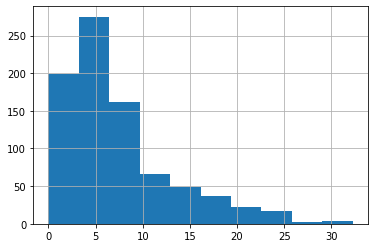

In [122]:
candidates_frame[candidates_frame['class'] == 1]['diameter_mm'].hist()

In [130]:
clim=(-1000.0, 300)


def showCandidate(series_uid, batch_ndx=None, **kwargs):
    ds = LunaDataset(series_uid=series_uid, **kwargs)
    pos_list = ds.candidates_frame[ds.candidates_frame['class'] == 1].index.to_list()
    if batch_ndx is None:
        if pos_list:
            batch_ndx = 0
        else:
            print("Warning: no positive samples found; using first negative sample.")
            batch_ndx = 0

    ct = Ct(series_uid)
    ct_t, pos_t, series_uid, center_irc = ds[batch_ndx]
    ct_a = ct_t[0].numpy()

    fig = plt.figure(figsize=(30, 50))

    group_list = [
        [9, 11, 13],
        [15, 16, 17],
        [19, 21, 23],
    ]

    subplot = fig.add_subplot(len(group_list) + 2, 3, 1)
    subplot.set_title('index {}'.format(int(center_irc[0])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.hu_a[int(center_irc[0])], clim=clim, cmap='gray')

    subplot = fig.add_subplot(len(group_list) + 2, 3, 2)
    subplot.set_title('row {}'.format(int(center_irc[1])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.hu_a[:,int(center_irc[1])], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 3)
    subplot.set_title('col {}'.format(int(center_irc[2])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.hu_a[:,:,int(center_irc[2])], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 4)
    subplot.set_title('index {}'.format(int(center_irc[0])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[ct_a.shape[0]//2], clim=clim, cmap='gray')

    subplot = fig.add_subplot(len(group_list) + 2, 3, 5)
    subplot.set_title('row {}'.format(int(center_irc[1])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[:,ct_a.shape[1]//2], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 6)
    subplot.set_title('col {}'.format(int(center_irc[2])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[:,:,ct_a.shape[2]//2], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    for row, index_list in enumerate(group_list):
        for col, index in enumerate(index_list):
            subplot = fig.add_subplot(len(group_list) + 2, 3, row * 3 + col + 7)
            subplot.set_title('slice {}'.format(index), fontsize=30)
            for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
                label.set_fontsize(20)
            plt.imshow(ct_a[index], clim=clim, cmap='gray')


    print(series_uid, batch_ndx, bool(pos_t[0]), pos_list)

<__main__.LunaDataset object at 0x7fc6b07ce320>: 993 training samples
2
1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886 0 False [0, 57, 182, 247, 530, 62676, 62677, 62704, 62924, 64528, 64565, 64824, 65035, 65116]


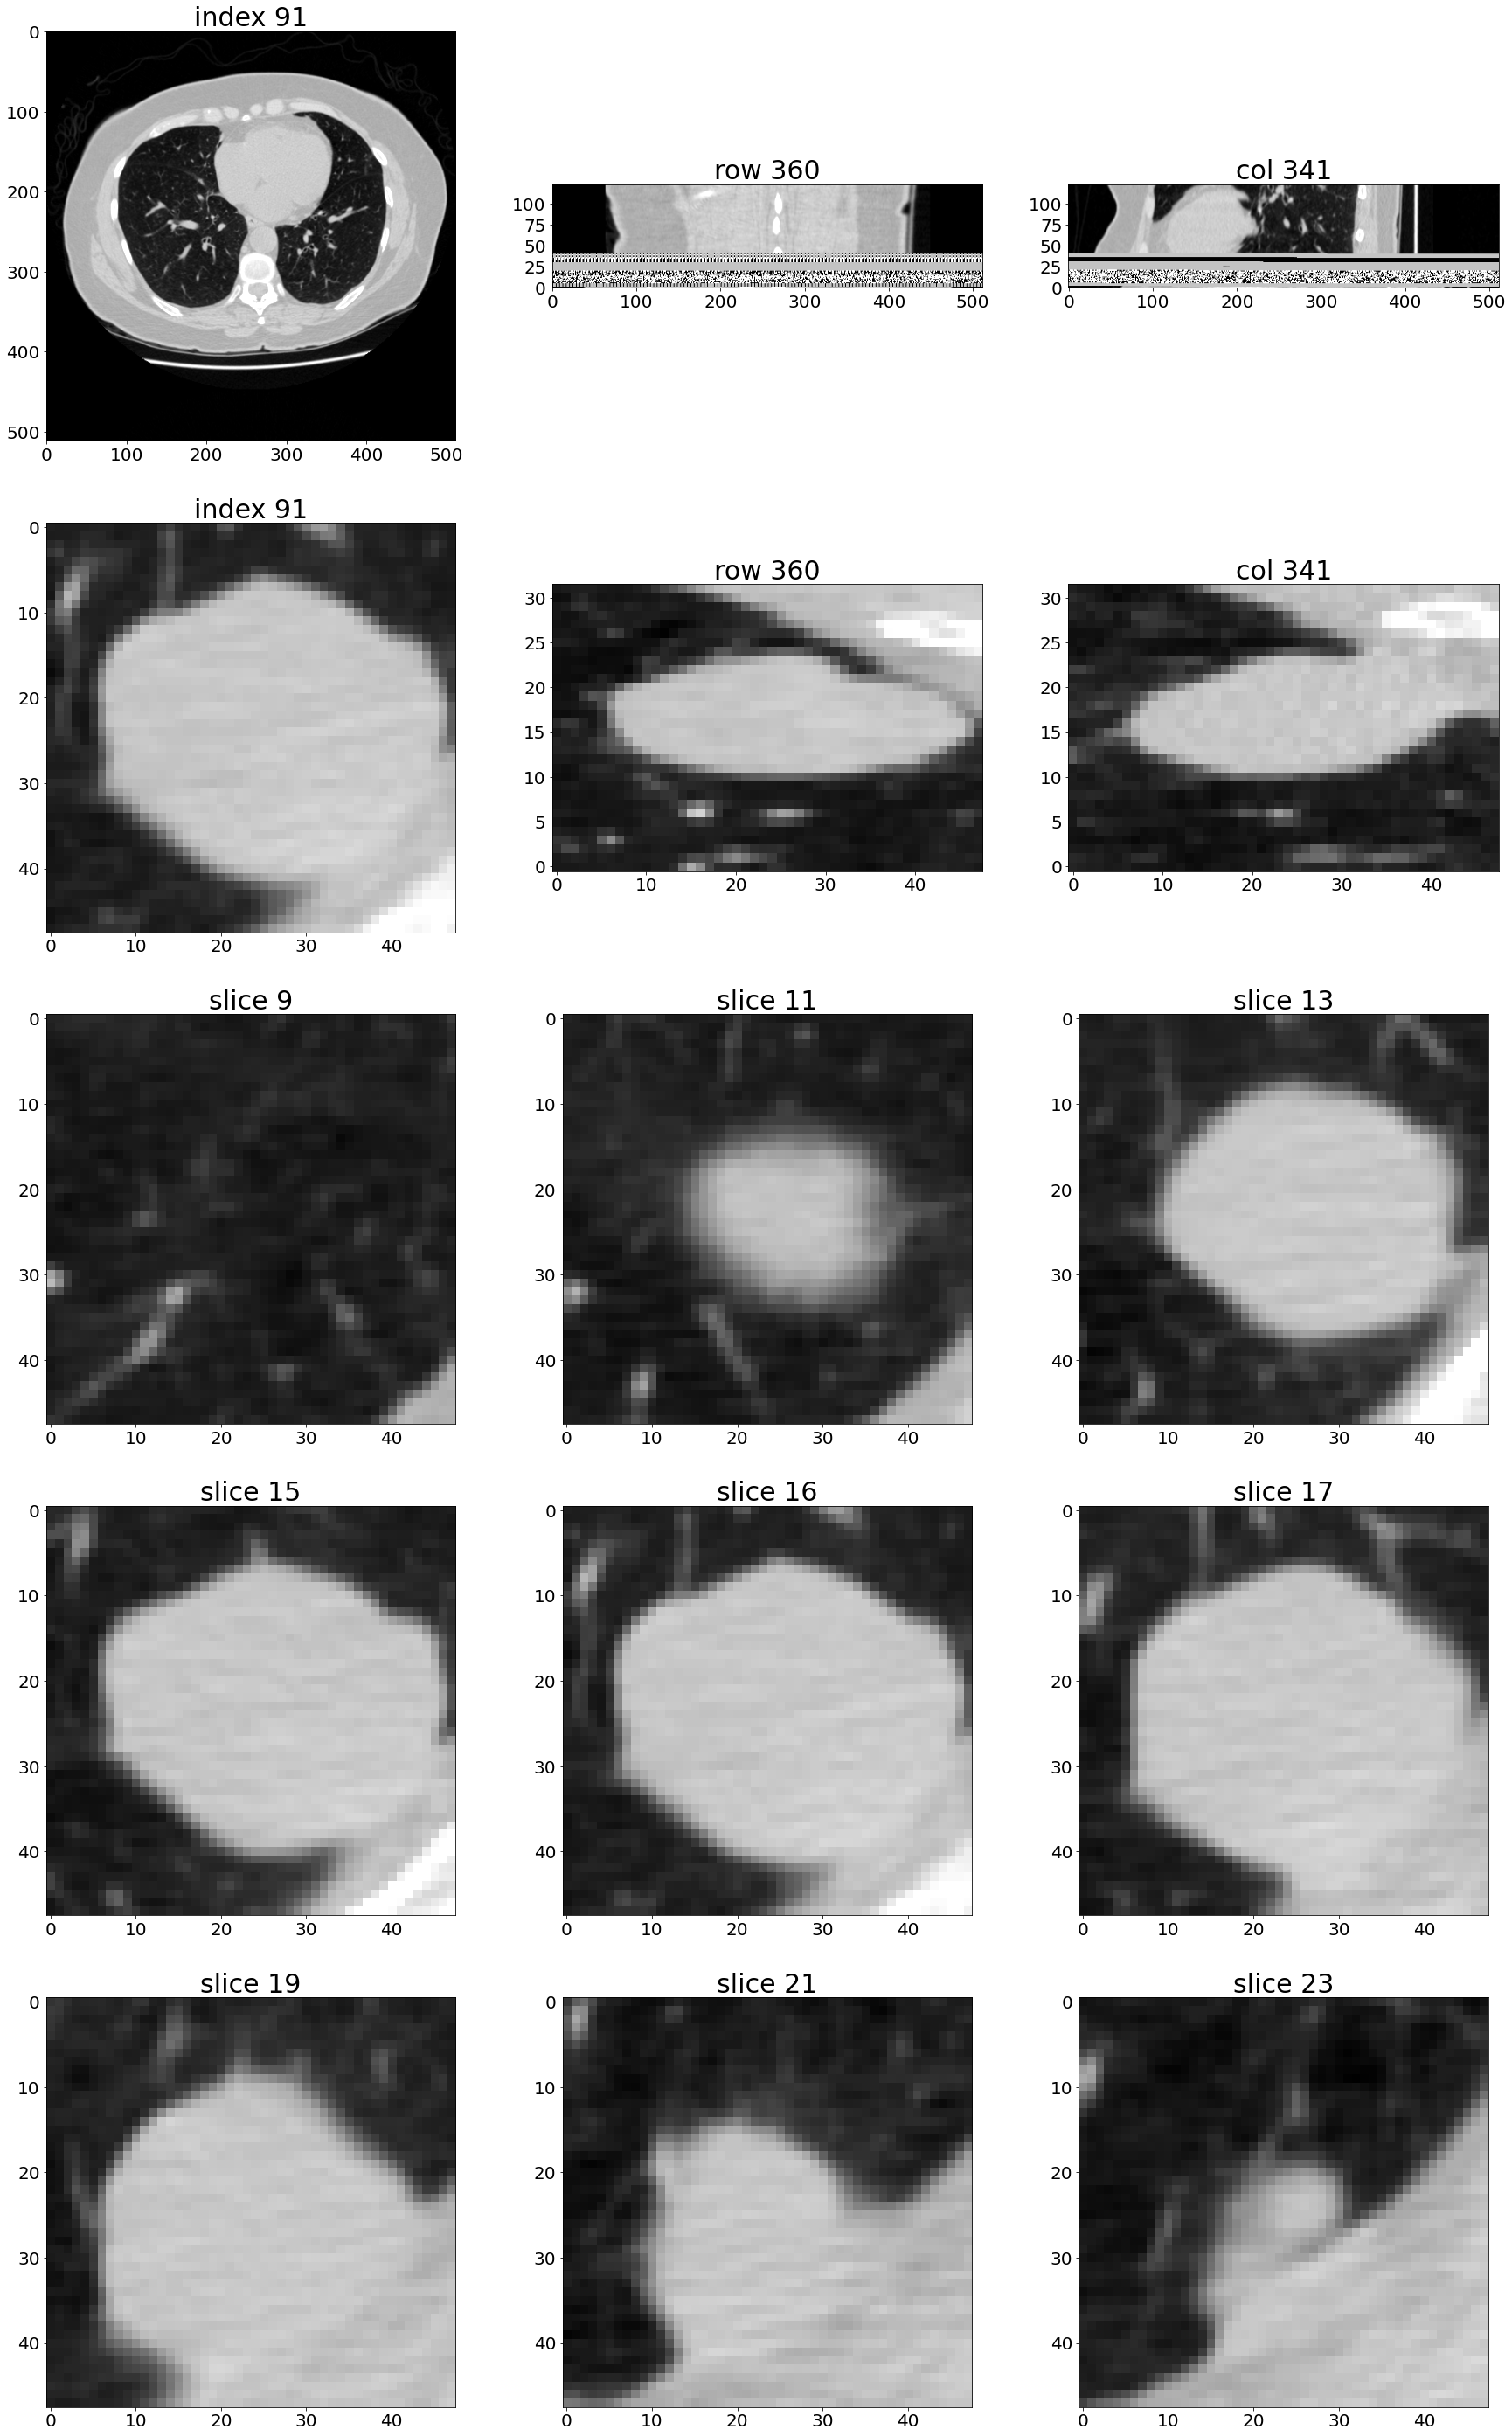

In [136]:
showCandidate('1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886')